# <b>SC1015 Mini-Project: Predicting Natural Disasters from Increasing Temperatures<b>

### Group 6 Members: Foo Jen Sean, Jeffrey Lim Yi Ren, Karishein Chandran
---
# Prediction and Modelling
---

Since ARIMA modelling does not take into account the seasonal aspects of a time series model, we decided to utilise Seasonal ARIMA, or SARIMA. SARIMA contains the same `p,d,q` parameters as ARIMA and additional `P,D,Q` seasonal parameters. The seasonal parameters is almost the same as the non-seasonal components, but they involve backshifts of the seasonal period. There is also a `m` value in the SARIMA model which denotes the number of observations per year or period.

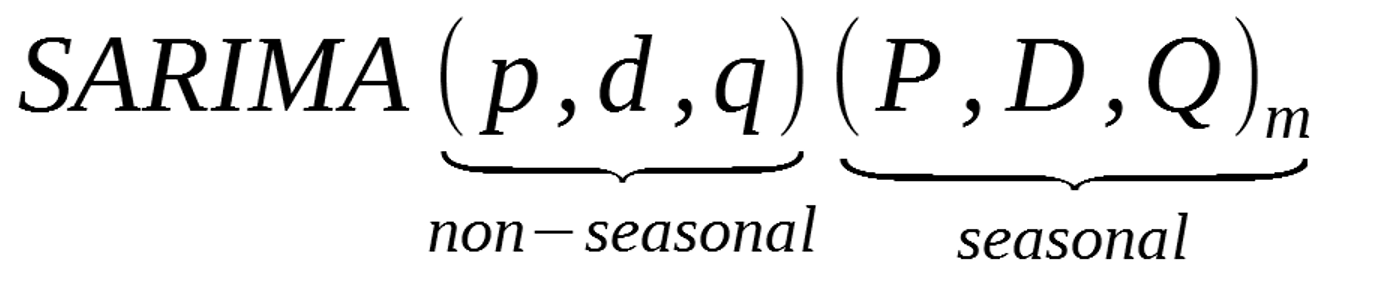

## Importing the necessary libraries:

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX 

from tqdm import tqdm_notebook
from itertools import product
import warnings
warnings.filterwarnings('ignore')

## CO2 Modelling
---

## Import the CO2 Dataset

- Drop unnecessary columns, as we only require the average concentrations of the gases

- Combine year and month columns together and casting it as a datetime data type and setting it to timestamp index

In [14]:
co2Data = pd.read_csv("co2_mm_mlo.csv")
co2Data_model = co2Data.drop(columns=["decimal date", "interpolated", "trend", "ndays"])
co2Data_model = co2Data_model.loc[:, ~co2Data_model.columns.str.match('Unnamed')]
co2Data_model['period'] = pd.to_datetime(co2Data_model[['year', 'month']].assign(Day=15))
co2Data_model = co2Data_model.set_index('period').to_period('M')
co2Data_model.index = co2Data_model.index.to_timestamp()
co2Data_model.drop(columns=["year", "month"], inplace=True)
co2Data_model.info()
co2Data_model.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 769 entries, 1958-03-01 to 2022-03-01
Freq: MS
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   average  769 non-null    float64
dtypes: float64(1)
memory usage: 12.0 KB


,average
period,
1958-03-01,315.70
1958-04-01,317.45
1958-05-01,317.51
1958-06-01,317.24
1958-07-01,315.86


## Plotting the Trend & Seasonality of CO2 Data

- <b>Trend</b>: Shows the increasing or decreasing values of the time series
- <b>Seasonality</b>: Shows the repeating short-term cycle in the time series
- <b>Residual</b>: Shows the deviation from the sample mean

The plots below is to find out the trend and seasonality of the CO2 emission timeseries from 1958-2022. There is a clear increase in the trend and a clear seasonal pattern. This shows that the timeseries is non-stationary.

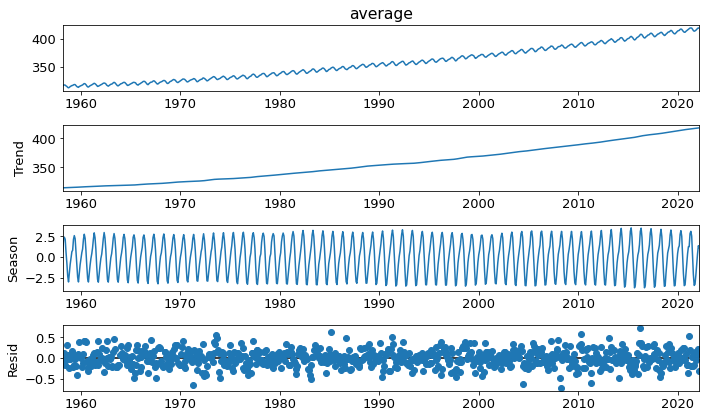

In [18]:
plt.rc('figure',figsize=(10,6))
plt.rc('font',size=13)
stl = STL(co2Data_model['average'], seasonal=7)
res = stl.fit()
fig = res.plot()

## Augmented Dickey-Fuller (ADF) Test of CO2 Data

Since the time series is not stationary, we can further perform an ADF Test to test its stationarity. The focus would be on the p-value, where a p-value <0.05 indicates that the time series is stationary.

To make a time series stationary, we can perfom a differencing operation on the required data. We will apply 1st-order differencing in this case and check the plot and p-value.

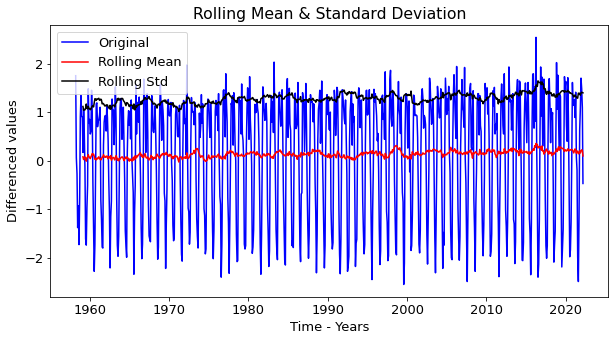

Results of Dickey-Fuller Test:
Test Statistic                  -5.245204
p-value                          0.000007
#Lags Used                      20.000000
Number of Observations Used    747.000000
Critical Value (1%)             -3.439134
Critical Value (5%)             -2.865417
Critical Value (10%)            -2.568834
dtype: float64
The time series is stationary at 95% level of confidence


In [16]:
def test_stationarity(timeseries, rolling=12):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(rolling).mean()
    rolstd = timeseries.rolling(rolling).std()

    #Plot rolling statistics:
    plt.figure(figsize=(10, 5))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.title('Power consumption Old data')
    plt.xlabel('Time - Years')
    plt.ylabel('Differenced values')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()

    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:') 
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used',
                                             'Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    if dfoutput['p-value'] < 0.05:
        print('The time series is stationary at 95% level of confidence')
    else:
        print('The time series is not stationary at 95% level of confidence')
        
        
co2_diff = co2Data_model['average'] - co2Data_model['average'].shift(1) # perform differencing operation
co2_diff = co2_diff.dropna()
test_stationarity(co2_diff, rolling=12)

After performing 1st Order Differencing, we can see that the p-value = 0.000007, which is less than 0.05, so we can safely say that the time series is stationary. From this, we can obtain our non-seasonal `d` value and the seasonal `D` value for the SARIMA parameters. Since we did 1st Order Differencing, both the value constitutes to 1, which is the `Integration (I)` component of the ARIMA model 

## Auto Correlation Function (ACF) Plot of CO2

An ACF plot is a visual way to show serial correlation in data that changes over time. The code below checks the plot for 40 time spots to see how the data are correlated across lags. We can use this to confirm high AR parameters as well as strong seasonality pattern.

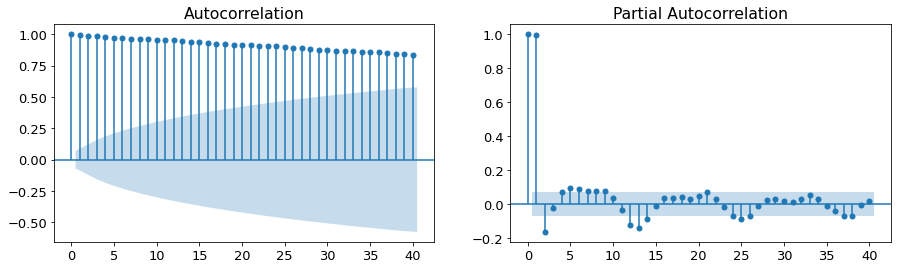

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(15,4))

fig = sm.graphics.tsa.plot_acf(co2Data_model['average'], lags=40, ax=axes[0])

fig = sm.graphics.tsa.plot_pacf(co2Data_model['average'], lags=40, ax=axes[1])

## Grid-Search for SARIMA parameters (p,q, & P,Q) for CO2

The function below is used to find the ideal parameters for the SARIMA model. The best parameters is chosen based on the Alkaline Information Criterion (AIC). The AIC is a mathematical method for evaluating how well a model fits the data it was generated from. In statistics, AIC is used to compare different possible models and determine which one is the best fit for the data. 

AIC is calculated from:

- The number of independent variables used to build the model.
- The maximum likelihood estimate of the model (how well the model reproduces the data).

We will select the parameters that produces the lowest AIC value

In [19]:
# Grid-search function for finding the p, q and seasonal parameters P, Q for the SARIMA model

def optimize_SARIMA(parameters_list, d, D, s, exog):
    """
        Return dataframe with parameters, corresponding AIC and SSE
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order
        D - seasonal integration order
        s - length of season
        exog - the exogenous variable
    """
    
    results = []
    
    for param in tqdm_notebook(parameters_list):
        try: 
            model = SARIMAX(exog, order=(param[0], d, param[1]), 
                            seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
            
        aic = model.aic
        results.append([param, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)x(P,Q)','AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

We will limit our range of parameters to 4, to reduce the computation time. `d` and `D` will be set to 1 as we will be differentiating once. The `s` here represents the `m` value discussed before. We set the `s` to 12 as our data is yearly and split into 12 months.  We have a total of 256 combinations that will be combined into a list and sent to the function.

In [72]:
p = range(0,4,1)
d = 1
q = range(0,4,1)

P = range(0,4,1)
D = 1
Q = range(0,4,1)

s = 12

parameters = product(p, q, P, Q)
parameters_list = list(parameters)
print(len(parameters_list))

256


In [73]:
result = optimize_SARIMA(parameters_list, 1, 1, 12, co2Data_model['average'])
result

  0%|          | 0/256 [00:00<?, ?it/s]

,"(p,q)x(P,Q)",AIC
0,"(1, 1, 0, 1)",403.489503
1,"(0, 3, 0, 1)",404.192436
2,"(0, 2, 0, 1)",404.440601
3,"(1, 1, 1, 2)",404.658874
4,"(2, 1, 0, 1)",404.768383
...,...,...
251,"(3, 0, 0, 0)",794.729414
252,"(2, 3, 0, 0)",794.923112
253,"(2, 0, 0, 0)",804.213655
254,"(1, 0, 0, 0)",812.056139


From the result above, we obtain the following parameters for the CO2 data based on the lowest AIC value:

Non-seasonal Parameters:
- p = 1
- d = 1
- q = 1

Seasonal Parameters
- P = 0
- D = 1
- Q = 1

## Train-Test Split for CO2

The function below splits the dataset into train and test. Since this is a timeseries data, we cannot do a random train-test split of the dataset. We will have to split it according to the years. Our train data will start from the beginning of the dataset till the end of 2016, while our test data will begin from 2017 till the end of the dataset.

In [22]:
# Function for splitting the train and test

def train_test_split(timeseries, lags_for_prediction):
    split=len(timeseries)-lags_for_prediction
    train=timeseries[:split]
    test=timeseries[split:]
    return train, test

train_co2, test_co2 = train_test_split(co2Data_model, 63)

In [23]:
train_co2

,average
period,
1958-03-01,315.70
1958-04-01,317.45
1958-05-01,317.51
1958-06-01,317.24
1958-07-01,315.86
...,...
2016-08-01,402.45
2016-09-01,401.23
2016-10-01,401.79


In [24]:
# test set starts from the year 2017
test_co2

,average
period,
2017-01-01,406.36
2017-02-01,406.66
2017-03-01,407.54
2017-04-01,409.22
2017-05-01,409.89
...,...
2021-11-01,415.01
2021-12-01,416.71
2022-01-01,418.19


## SARIMA Prediction & Plot of CO2

The function below is used to model the data using SARIMA and helps to predict future values. The function also plots out the predictions with the test data for comparison and a fitted summary of the SARIMA model.

The plot below shows that the prediction is almost accurate, as it aligns with the test data. Thus we can be say that the SARIMA prediction of the CO2 data is good.

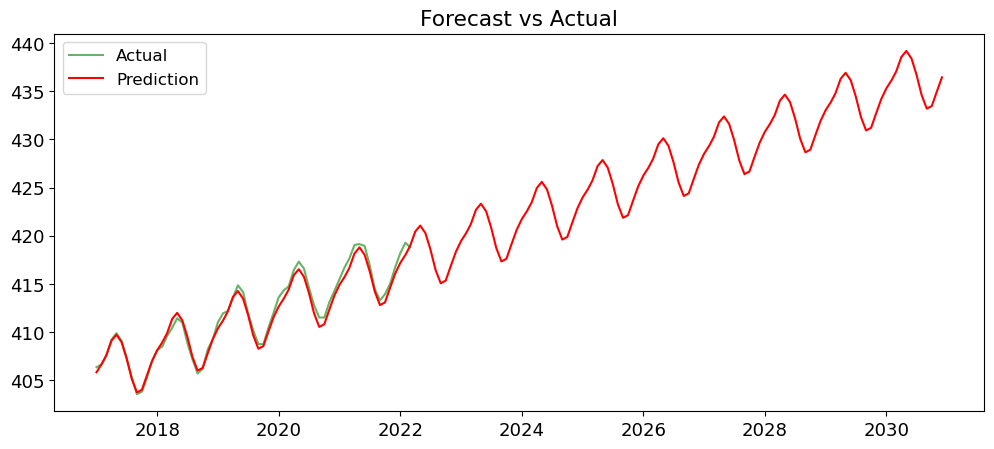

                                     SARIMAX Results                                      
Dep. Variable:                            average   No. Observations:                  706
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -178.516
Date:                            Sat, 23 Apr 2022   AIC                            365.032
Time:                                    19:13:03   BIC                            383.196
Sample:                                03-01-1958   HQIC                           372.057
                                     - 12-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2220      0.089      2.504      0.012       0.048       0.396
ma.L1         -0.5657      0.076   

In [26]:
def forecasting (p,d,q,P,D,Q,season, lags_for_forecast, train, test):

    model = SARIMAX(train, order=(p,d,q), seasonal_order=(P,D,Q,season),
                                             simple_differencing=0, #if True time series provided as endog is literally differenced and an ARMA model is fit to the resulting new time series
                                             enforce_stationarity=True,
                                             enforce_invertibility=False)
    fitted = model.fit(disp=-1)  
    
    start = '2017-01-01' # start of prediction
    end = '2030-12-01'   # end of prediction
    
    # Forecast
    forecast = fitted.predict(start=start,end=end,typ='levels')

    # Plot
    plt.figure(figsize=(12,5), dpi=100)
    #plt.plot(train, color='blue', label='train')
    plt.plot(test, color='green', label='Actual', alpha=0.6)
    plt.plot(forecast, color='red', label = 'Prediction')
    plt.title('Forecast vs Actual')
    plt.legend(loc='upper left', fontsize=12)
    plt.show()
    
    from sklearn import metrics
    from math import sqrt

    #print('\033[1m' + 'MAE: ' + '\033[0m', metrics.mean_absolute_error(test, forecast))
    #print('\033[1m' + 'MSE: ' + '\033[0m', metrics.mean_squared_error(test, forecast))
    #print('\033[1m' + 'RMSE:' + '\033[0m', np.sqrt(metrics.mean_squared_error(test, forecast)))
    #print('\033[1m' + 'MEAN:' + '\033[0m', test.mean())
    
    #RSS=np.sqrt(sum(forecast.values-test['average'].values.reshape(-1))**2)/lags_for_forecast

    print(fitted.summary())
    
    return forecast
    
forecast_co2 = forecasting (1,1,1, 0,1,1, 12, 63, train_co2['average'], test_co2['average'])

---

## CH4 Modelling
---

## Import the CH4 Dataset

In [28]:
ch4Data = pd.read_csv('https://raw.githubusercontent.com/Dumbledore66/Mini-Project/main/ch4_mm_gl.csv')
ch4Data_model = ch4Data.drop(columns=["decimal", "average_unc", "trend", "trend_unc"])
ch4Data_model['period'] = pd.to_datetime(ch4Data_model[['year', 'month']].assign(Day=15))
ch4Data_model = ch4Data_model.set_index('period').to_period('M')
ch4Data_model.index = ch4Data_model.index.to_timestamp()
ch4Data_model.drop(columns=["year", "month"], inplace=True)
ch4Data_model.info()
ch4Data_model.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 462 entries, 1983-07-01 to 2021-12-01
Freq: MS
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   average  462 non-null    float64
dtypes: float64(1)
memory usage: 7.2 KB


,average
period,
1983-07-01,1625.9
1983-08-01,1628.1
1983-09-01,1638.4
1983-10-01,1644.8
1983-11-01,1642.6


## Plotting the Trend & Seasonality of CH4 Data

The plots below is to find out the trend and seasonality of the CH4 emission timeseries from 1983-2021. There is a clear increase in the trend and a clear seasonal pattern. This shows that the timeseries is non-stationary.

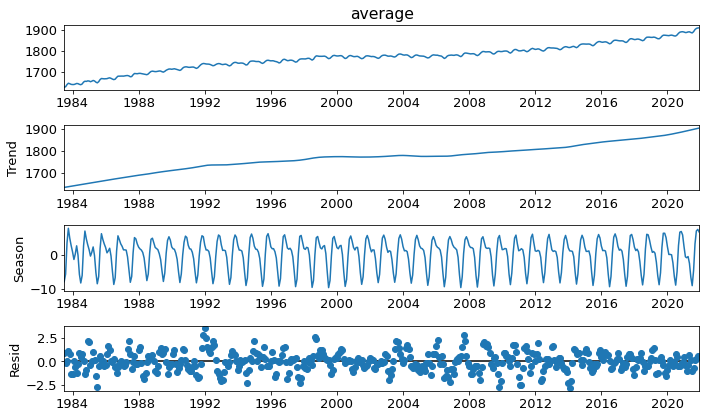

In [31]:
plt.rc('figure',figsize=(10,6))
plt.rc('font',size=13)
stl = STL(ch4Data_model['average'], seasonal=7)
res = stl.fit()
fig = res.plot()

## Augmented Dickey-Fuller (ADF) Test of CH4 Data

Since the time series is not stationary, we can further perform an ADF Test to test its stationarity. The focus would be on the p-value, where a p-value <0.05 indicates that the time series is stationary.

To make a time series stationary, we can perfom a differencing operation on the required data. We will apply 1st-order differencing in this case and check the plot and p-value.

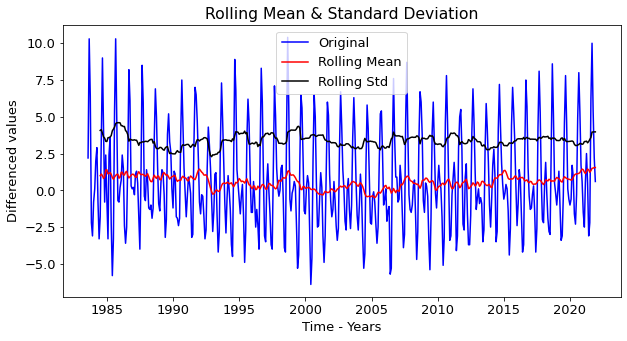

Results of Dickey-Fuller Test:
Test Statistic                  -3.089793
p-value                          0.027318
#Lags Used                      12.000000
Number of Observations Used    448.000000
Critical Value (1%)             -3.445031
Critical Value (5%)             -2.868013
Critical Value (10%)            -2.570218
dtype: float64
The time series is stationary at 95% level of confidence


In [30]:
ch4_diff = ch4Data_model['average'] - ch4Data_model['average'].shift(1)
ch4_diff = ch4_diff.dropna()
test_stationarity(ch4_diff, rolling=12)

After performing 1st Order Differencing, we can see that the p-value = 0.027318 , which is less than 0.05, so we can safely say that the time series is stationary. From this, we can obtain our non-seasonal `d` value and the seasonal `D` value for the SARIMA parameters. Since we did 1st Order Differencing, both the value constitutes to 1, which is the `Integration (I)` component of the ARIMA model 

## Auto Correlation Function (ACF) Plot of CH4

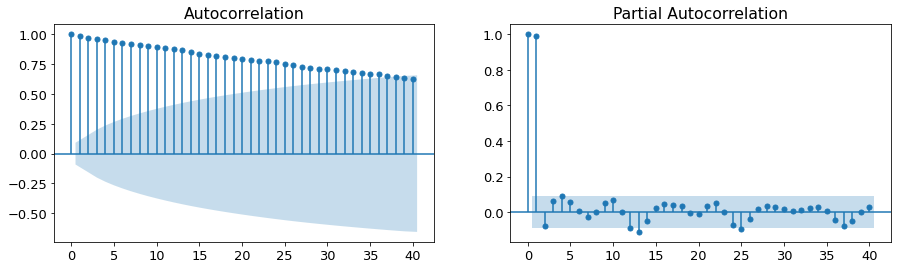

In [33]:
fig, axes = plt.subplots(1, 2, figsize=(15,4))

fig = sm.graphics.tsa.plot_acf(ch4Data_model['average'], lags=40, ax=axes[0])

fig = sm.graphics.tsa.plot_pacf(ch4Data_model['average'], lags=40, ax=axes[1])

## Grid-Search for SARIMA parameters (p,q, & P,Q) for CH4

In [74]:
result = optimize_SARIMA(parameters_list, 1, 1, 12, ch4Data_model['average'])
result

  0%|          | 0/256 [00:00<?, ?it/s]

,"(p,q)x(P,Q)",AIC
0,"(3, 3, 0, 1)",1018.016256
1,"(3, 3, 0, 2)",1018.101782
2,"(3, 3, 1, 1)",1019.420306
3,"(3, 3, 1, 2)",1020.110575
4,"(3, 3, 2, 1)",1020.320659
...,...,...
251,"(1, 0, 1, 0)",1481.406497
252,"(0, 0, 2, 0)",1494.954549
253,"(0, 0, 1, 0)",1540.265992
254,"(1, 0, 0, 0)",1582.016143


From the result above, we obtain the following parameters for the CH4 data based on the lowest AIC value:

Non-seasonal Parameters:
- p = 3
- d = 1
- q = 3

Seasonal Parameters
- P = 0
- D = 1
- Q = 1

## Train-Test Split for CH4

Similar to CO2, we will start our test data from 2017 till the end of the dataset.

In [42]:
train_ch4, test_ch4 = train_test_split(ch4Data_model, 60)

In [43]:
train_ch4

,average
period,
1983-07-01,1625.9
1983-08-01,1628.1
1983-09-01,1638.4
1983-10-01,1644.8
1983-11-01,1642.6
...,...
2016-08-01,1836.8
2016-09-01,1844.3
2016-10-01,1850.0


In [44]:
test_ch4.head()

,average
period,
2017-01-01,1849.8
2017-02-01,1848.6
2017-03-01,1848.3
2017-04-01,1848.6
2017-05-01,1847.2


## SARIMA Prediction & Plot of CH4

The prediction for the CH4 SARIMA model seems to be almost accurate, as it aligns with the test data at the start. However, there seems to be a lag, as the year goes by. Nevertheless, we can still use this to predict the future values of CH4 concentrations.

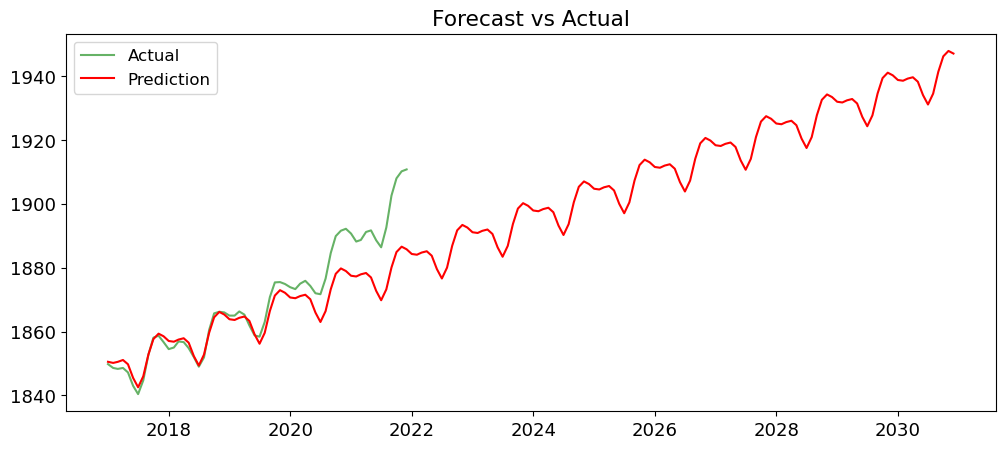

                                      SARIMAX Results                                       
Dep. Variable:                              average   No. Observations:                  402
Model:             SARIMAX(3, 1, 3)x(0, 1, [1], 12)   Log Likelihood                -442.599
Date:                              Sat, 23 Apr 2022   AIC                            901.197
Time:                                      19:34:15   BIC                            932.906
Sample:                                  07-01-1983   HQIC                           913.768
                                       - 12-01-2016                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0235      2.600     -0.009      0.993      -5.119       5.072
ar.L2         -0.24

In [45]:
forecast_ch4 = forecasting (3,1,3, 0,1,1, 12, 60, train_ch4['average'], test_ch4['average'])

---

## N2O Modelling

---

## Import the N20 Dataset

In [47]:
n2oData = pd.read_csv('https://raw.githubusercontent.com/Dumbledore66/Mini-Project/main/n2o_mm_gl.csv')
n2oData_model = n2oData.drop(columns=["decimal", "average_unc", "trend", "trend_unc"])
n2oData_model['period'] = pd.to_datetime(n2oData_model[['year', 'month']].assign(Day=15))
n2oData_model = n2oData_model.set_index('period').to_period('M')
n2oData_model.index = n2oData_model.index.to_timestamp()
n2oData_model.drop(columns=["year", "month"], inplace=True)
n2oData_model.info()
n2oData_model.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 252 entries, 2001-01-01 to 2021-12-01
Freq: MS
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   average  252 non-null    float64
dtypes: float64(1)
memory usage: 3.9 KB


,average
period,
2001-01-01,316.3
2001-02-01,316.3
2001-03-01,316.2
2001-04-01,316.1
2001-05-01,316.1


## Plotting the Trend & Seasonality of N2O Data

The plots below is to find out the trend and seasonality of the N2O emission timeseries from 2001-2021. There is a clear increase in the trend and a clear seasonal pattern. This shows that the timeseries is non-stationary.

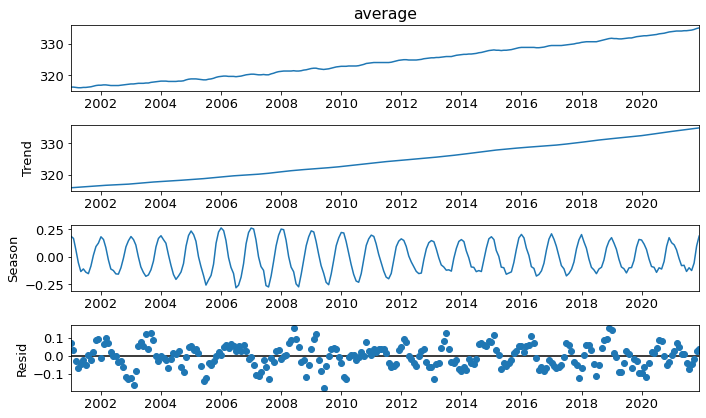

In [50]:
plt.rc('figure',figsize=(10,6))
plt.rc('font',size=13)
stl = STL(n2oData_model['average'], seasonal=7)
res = stl.fit()
fig = res.plot()

## Augmented Dickey-Fuller (ADF) Test of N2O Data

Since the time series is not stationary, we can further perform an ADF Test to test its stationarity. The focus would be on the p-value, where a p-value <0.05 indicates that the time series is stationary.

To make a time series stationary, we can perfom a differencing operation on the required data. We will apply 1st-order differencing in this case and check the plot and p-value.

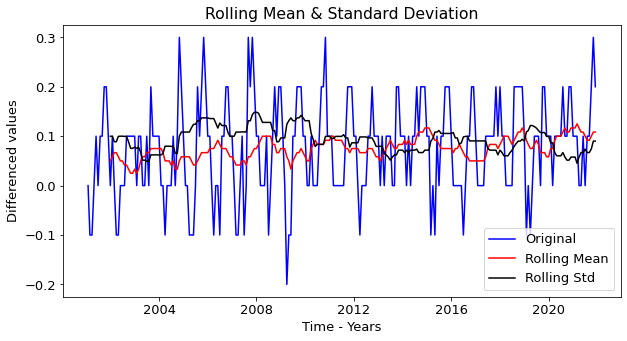

Results of Dickey-Fuller Test:
Test Statistic                  -3.017139
p-value                          0.033325
#Lags Used                      12.000000
Number of Observations Used    238.000000
Critical Value (1%)             -3.458128
Critical Value (5%)             -2.873762
Critical Value (10%)            -2.573283
dtype: float64
The time series is stationary at 95% level of confidence


In [51]:
n2o_diff = n2oData_model['average'] - n2oData_model['average'].shift(1)
n2o_diff = n2o_diff.dropna()
test_stationarity(n2o_diff, rolling=12)

After performing 1st Order Differencing, we can see that the p-value = 0.033325 , which is less than 0.05, so we can safely say that the time series is stationary. From this, we can obtain our non-seasonal `d` value and the seasonal `D` value for the SARIMA parameters. Since we did 1st Order Differencing, both the value constitutes to 1, which is the `Integration (I)` component of the ARIMA model 

## Auto Correlation Function (ACF) Plot of N2O

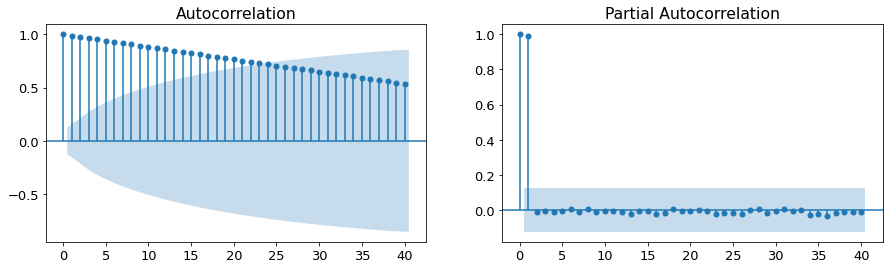

In [52]:
fig, axes = plt.subplots(1, 2, figsize=(15,4))

fig = sm.graphics.tsa.plot_acf(n2oData_model['average'], lags=40, ax=axes[0])

fig = sm.graphics.tsa.plot_pacf(n2oData_model['average'], lags=40, ax=axes[1])

## Grid-Search for SARIMA parameters (p,q, & P,Q) for N2O

In [76]:
result = optimize_SARIMA(parameters_list, 1, 1, 12, n2oData_model['average'])
result

  0%|          | 0/256 [00:00<?, ?it/s]

,"(p,q)x(P,Q)",AIC
0,"(1, 0, 0, 1)",-609.121254
1,"(2, 3, 0, 1)",-608.443036
2,"(2, 3, 0, 2)",-608.073949
3,"(1, 0, 2, 1)",-607.968584
4,"(1, 0, 0, 3)",-607.957732
...,...,...
251,"(1, 1, 0, 0)",-482.411572
252,"(3, 0, 0, 0)",-481.834674
253,"(0, 3, 0, 0)",-480.981364
254,"(2, 1, 0, 0)",-480.594244


From the result above, we obtain the following parameters for the N2O data based on the lowest AIC value:

Non-seasonal Parameters:
- p = 1
- d = 1
- q = 0

Seasonal Parameters
- P = 0
- D = 1
- Q = 1

## Train-Test Split for N2O

Our test data starts from 2017 till the end of the dataset.

In [53]:
train_n2o, test_n2o = train_test_split(n2oData_model, 60)

In [57]:
train_n2o

,average
period,
2001-01-01,316.3
2001-02-01,316.3
2001-03-01,316.2
2001-04-01,316.1
2001-05-01,316.1
...,...
2016-08-01,328.8
2016-09-01,328.9
2016-10-01,329.0


In [59]:
test_n2o.head()

,average
period,
2017-01-01,329.5
2017-02-01,329.5
2017-03-01,329.5
2017-04-01,329.5
2017-05-01,329.5


## SARIMA Prediction & Plot of N2O

The N2O preidctions seem to have more lag as compared to the test data. This may be due to the smaller number of data points for the train set, which may have affected the predictions.

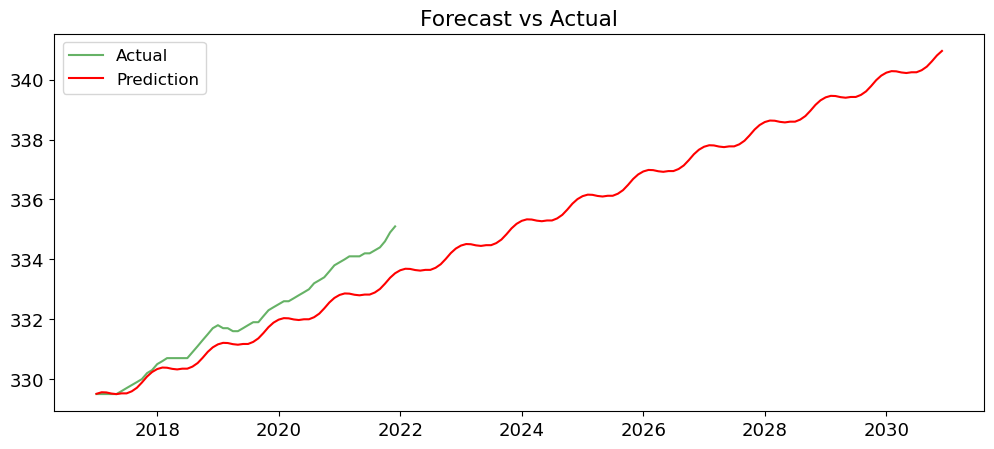

                                      SARIMAX Results                                       
Dep. Variable:                              average   No. Observations:                  192
Model:             SARIMAX(1, 1, 0)x(0, 1, [1], 12)   Log Likelihood                 224.485
Date:                              Sat, 23 Apr 2022   AIC                           -442.969
Time:                                      19:52:05   BIC                           -433.407
Sample:                                  01-01-2001   HQIC                          -439.092
                                       - 12-01-2016                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1706      0.078      2.198      0.028       0.018       0.323
ma.S.L12      -1.00

In [60]:
forecast_n2o = forecasting (1,1,0, 0,1,1, 12, 60, train_n2o['average'], test_n2o['average'])

---

## Temperature Change Modelling

---

## Import the Temperature Change Dataset

In [63]:
tempData = pd.read_csv('https://raw.githubusercontent.com/Dumbledore66/Mini-Project/main/climate-change-temperature.csv')
tempData_model = tempData.drop(columns=["Code"])
tempData_model = tempData_model[tempData_model.Entity == 'World']

tempData_model = tempData_model.set_index('Day')
tempData_model.index = tempData_model.index.astype(str)
tempData_model.index = pd.DatetimeIndex(tempData_model.index).to_period("M")
tempData_model.index = tempData_model.index.to_timestamp()
tempData_model.info()
tempData_model.head()tempData_model

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1705 entries, 1880-01-01 to 2022-01-01
Freq: MS
Data columns (total 2 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Entity               1705 non-null   object 
 1   temperature_anomaly  1705 non-null   float64
dtypes: float64(1), object(1)
memory usage: 40.0+ KB


,Entity,temperature_anomaly
Day,,
1880-01-01,World,-0.17
1880-02-01,World,-0.23
1880-03-01,World,-0.08
1880-04-01,World,-0.15
1880-05-01,World,-0.09


## Plotting the Trend & Seasonality of Temperature Change Data

The plots below is to find out the trend and seasonality of the Temperature change timeseries from 1880-2022. There seems to be only a slight increase in trend but there is some obvious seasonal pattern. Since the data values seems to be increasing overall, we can say that the timeseries is non-stationary

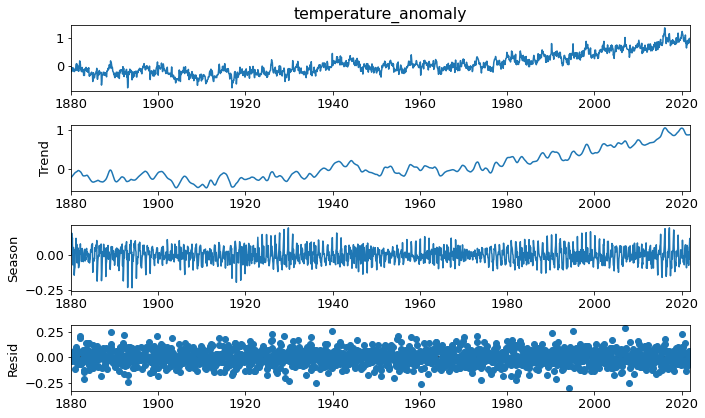

In [65]:
plt.rc('figure',figsize=(10,6))
plt.rc('font',size=13)
stl = STL(tempData_model['temperature_anomaly'], seasonal=7)
res = stl.fit()
fig = res.plot()

## Augmented Dickey-Fuller (ADF) Test of Temperature Change Data

Since the time series is not stationary, we can further perform an ADF Test to test its stationarity. The focus would be on the p-value, where a p-value <0.05 indicates that the time series is stationary.

To make a time series stationary, we can perfom a differencing operation on the required data. We will apply 1st-order differencing in this case and check the plot and p-value.

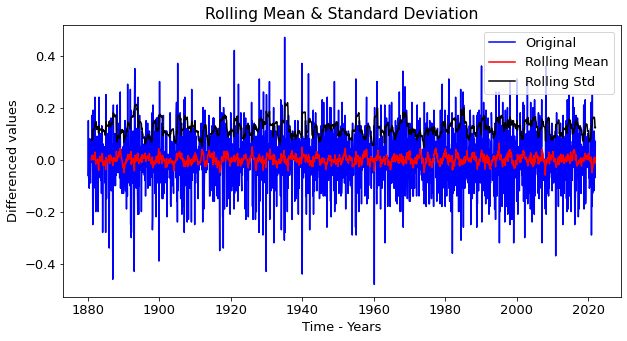

Results of Dickey-Fuller Test:
Test Statistic                -1.236645e+01
p-value                        5.400854e-23
#Lags Used                     2.300000e+01
Number of Observations Used    1.680000e+03
Critical Value (1%)           -3.434248e+00
Critical Value (5%)           -2.863262e+00
Critical Value (10%)          -2.567687e+00
dtype: float64
The time series is stationary at 95% level of confidence


In [13]:
temp_diff = tempData_model['temperature_anomaly'] - tempData_model['temperature_anomaly'].shift(1)
temp_diff = temp_diff.dropna()
test_stationarity(temp_diff, rolling=12)

After performing 1st Order Differencing, we can see that the p-value = 5.400854e-23, which is less than 0.05, so we can safely say that the time series is stationary. From this, we can obtain our non-seasonal `d` value and the seasonal `D` value for the SARIMA parameters. Since we did 1st Order Differencing, both the value constitutes to 1, which is the `Integration (I)` component of the ARIMA model 

## Auto Correlation Function (ACF) Plot of Temperature Change

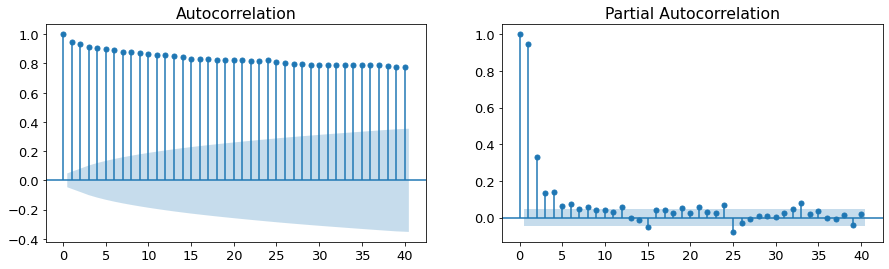

In [66]:
fig, axes = plt.subplots(1, 2, figsize=(15,4))

fig = sm.graphics.tsa.plot_acf(tempData_model['temperature_anomaly'], lags=40, ax=axes[0])

fig = sm.graphics.tsa.plot_pacf(tempData_model['temperature_anomaly'], lags=40, ax=axes[1])

## Grid-Search for SARIMA parameters (p,q, & P,Q) for Temperature Change

In [75]:
result = optimize_SARIMA(parameters_list, 1, 1, 12, tempData_model['temperature_anomaly'])
result

  0%|          | 0/256 [00:00<?, ?it/s]

,"(p,q)x(P,Q)",AIC
0,"(1, 2, 2, 2)",-2723.944101
1,"(1, 2, 1, 3)",-2723.537850
2,"(1, 2, 2, 1)",-2723.115638
3,"(1, 2, 0, 3)",-2721.783785
4,"(2, 3, 1, 3)",-2721.181515
...,...,...
251,"(0, 1, 0, 0)",-1566.424594
252,"(3, 0, 0, 0)",-1559.697678
253,"(2, 0, 0, 0)",-1532.057712
254,"(1, 0, 0, 0)",-1481.963242


From the result above, we obtain the following parameters for the Temperature Change data based on the lowest AIC value:

Non-seasonal Parameters:
- p = 1
- d = 1
- q = 2

Seasonal Parameters
- P = 2
- D = 1
- Q = 2

## Train-Test Split for Temperature Change

Our test data starts from 2017 till the end of the dataset.

In [67]:
train_temp, test_temp = train_test_split(tempData_model, 61)

In [68]:
train_temp

,Entity,temperature_anomaly
Day,,
1880-01-01,World,-0.17
1880-02-01,World,-0.23
1880-03-01,World,-0.08
1880-04-01,World,-0.15
1880-05-01,World,-0.09
...,...,...
2016-08-01,World,1.02
2016-09-01,World,0.90
2016-10-01,World,0.89


In [69]:
test_temp

,Entity,temperature_anomaly
Day,,
2017-01-01,World,1.02
2017-02-01,World,1.14
2017-03-01,World,1.16
2017-04-01,World,0.94
2017-05-01,World,0.91
...,...,...
2021-09-01,World,0.92
2021-10-01,World,0.99
2021-11-01,World,0.93


## SARIMA Prediction & Plot of Temperature Change

The temperature change predictions, does not seem to follow the test data points, but instead seems to lie in the middle of the data points. This may be quite accurate in predictions, as the data set may have outliers that may affect the results.

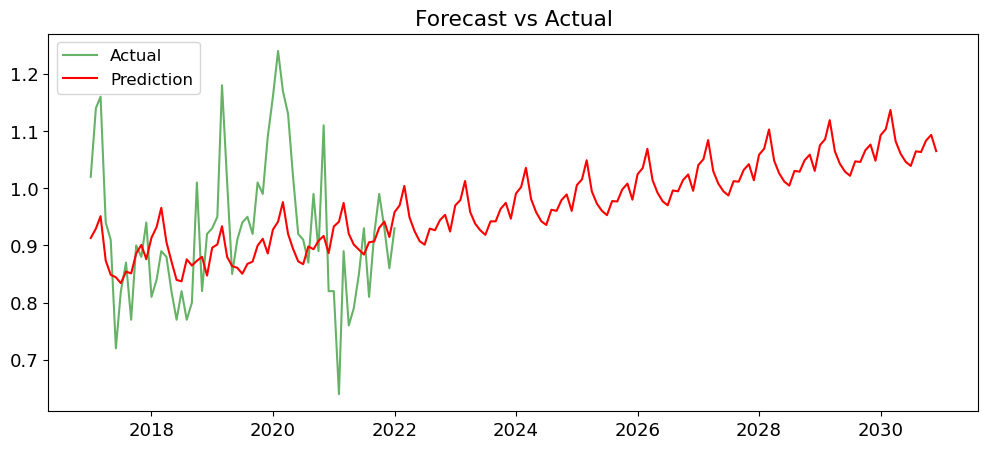

                                     SARIMAX Results                                      
Dep. Variable:                temperature_anomaly   No. Observations:                 1644
Model:             SARIMAX(1, 1, 2)x(2, 1, 2, 12)   Log Likelihood                1313.667
Date:                            Sat, 23 Apr 2022   AIC                          -2611.334
Time:                                    20:18:54   BIC                          -2568.158
Sample:                                01-01-1880   HQIC                         -2595.317
                                     - 12-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8656      0.022     38.579      0.000       0.822       0.910
ma.L1         -1.3759      0.034   

In [70]:
forecast_temp = forecasting (1,1,2, 2,1,2, 12, 61, train_temp['temperature_anomaly'], test_temp['temperature_anomaly'])

---